In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

('corpus length:', 600901)


In [4]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

('total chars:', 59)


In [19]:
sent = text.split('\n')

In [22]:
lengths = []

for ix in sent:
    lengths.append(len(ix))

In [25]:
uniq, nums = np.unique(np.array(lengths), return_counts=True)

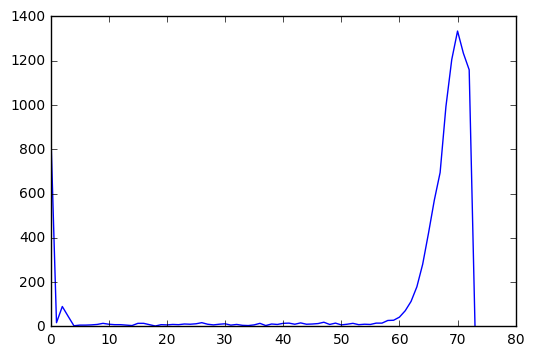

In [32]:
plt.plot(nums)
plt.show()

In [35]:
maxlen = 50
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

('nb sequences:', 200284)


In [37]:
len(sentences)

200284

In [36]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [50]:
print indices_char[np.argmax(X[0][1])]
# print y[0]

r


In [40]:
model = Sequential()
model.add(LSTM(256, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.summary()

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               323584    
_________________________________________________________________
dense_2 (Dense)              (None, 59)                15163     
_________________________________________________________________
activation_2 (Activation)    (None, 59)                0         
Total params: 338,747.0
Trainable params: 338,747.0
Non-trainable params: 0.0
_________________________________________________________________


In [81]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return probas
    # return np.argmax(probas)

In [107]:
prob = np.array([0.2, 0.1, 0.4, 0.15, 0.05, 0.1])

a = sample(prob, temperature=1.1)

print prob
print a

#plt.plot(prob)
#plt.plot(a, 'r--*')

[ 0.2   0.1   0.4   0.15  0.05  0.1 ]
[[0 0 0 1 0 0]]


In [109]:
for iteration in range(1, 10):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, shuffle=True,
              batch_size=128,
              epochs=1, verbose=2)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

()
--------------------------------------------------
('Iteration', 1)
Epoch 1/1


KeyboardInterrupt: 